In [1]:
from urllib2 import urlopen, Request
from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import numpy as np
import re
import os.path 
import datetime 
import sys
import json
import gc


from __future__ import division

import nltk,re, pprint

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

bs = BeautifulSoup(urlopen('http://www.playbill.com/article/broadway-real-estate-com-321997'))
Theatres = DataFrame([{'name': a.getText(), 'url': a['href'], 'address': a.nextSibling[2:]} 
                      for a in bs.find_all("a") if a.has_attr('href') and '/venue/' in a['href']])

Shows = pd.read_csv('Shows.csv')

def getTags(url):
    bs = BeautifulSoup(urlopen('http://www.playbill.com' + url))
    return sorted(set([x.getText() for x in bs.find_all('h5', class_='bsp-bio-sub-text')]))

def getTagsFromBs(bs):
    return sorted(set([x.getText() for x in bs.find_all('h5', class_='bsp-bio-sub-text')]))

def seasonShows(season):
    seasonJson = json.loads(''.join(urlopen('http://www.playbill.com/ajax/loadProdSeason.jsp?year='+str(season)+'&start=0&limit=1000').readlines()))
    result = []
    for row in seasonJson['rows']:

        bs = BeautifulSoup(row)
        if (bs.find('a').has_attr('href')):
            result.append({'url':bs.find('a')['href'], 'title': bs.find('a').getText()})
    return result

def getProductionHtml(url):
    if (not url.startswith('http://www.playbill.com')):
        url = 'http://www.playbill.com' + url

    filename = 'production/' + url.split('/')[-1] + '.html' 

    if (not os.path.isfile(filename)):
        html = urlopen(url).read()
        f = open(filename, "w")
        f.write(html)
        f.close()
        print 'Wrote ' + filename
    else:
        print filename + ' already exists'

def getHtmlForYear(year):
    print 'Year: ' + str(year)
    [getProductionHtml(x) for x in list(Shows[Shows['year']==year]['url'])]
    
Shows['decade'] = 10 * (Shows['year'] // 10)
Shows['urlMinusVaultId'] = Shows['url'].apply(lambda url: '-'.join(url.split('-')[:-2]))
Shows['isMusical'] = Shows.tags.str.contains('Musical')
Shows['isComedy'] = Shows.tags.str.contains('Comedy')
Shows['isDrama'] = Shows.tags.str.contains('Drama')
Shows['isPlay'] = Shows.tags.str.contains('Play')


In [ ]:
BLOCK
tagsForUrl = {}

for year in range(1700,2018):
    print datetime.datetime.now()
    print year,
    for url in list(Shows[Shows['year'] == year]['url']):
        filename = (url + '.html')[1:]
        if (os.path.isfile(filename)):
            f = open(filename)
            bs = BeautifulSoup(f.read())
            f.close()
            tagsForUrl[url] = '/'.join(getTagsFromBs(bs))
            bs.decompose()
            gc.collect() #BeautifulSoup memory leak!!!! :(((
            print ".",
        else:
            print filename + ' not found'
    print
print datetime.datetime.now()

Shows.to_csv('Shows.csv',index=False,encoding='utf-8')

In [38]:
descriptionsForUrl = {}

for year in range(1700,2018):
    print datetime.datetime.now()
    print year,
    for url in list(Shows[Shows['year'] == 2017]['url']):
        filename = (url + '.html')[1:]
        if (os.path.isfile(filename)):
            f = open(filename)
            bs = BeautifulSoup(f.read())
            f.close()
            descriptionsForUrl[url] = [meta['content'] for meta in bs.find_all('meta') if meta.has_attr('name') and meta['name'] == 'description'][0]
            bs.decompose()
            gc.collect() #BeautifulSoup memory leak!!!! :(((
            print ".",
        else:
            print filename + ' not found'
    print
print datetime.datetime.now()

descriptionsForUrl

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

{'/production/1984-hudson-theatre-2017-2018': 'Winston Smith works for the Ministry of Truth, rewriting newspaper articles so that history always supports the views of the Party. But when Winston has a thought, writes a diary and falls in love, he does so under the ever watchful eye of Big Brother.',
 '/production/angels-in-america-a-gay-fantasia-on-national-themes-neil-simon-theatre-2017-2018': "A quarter-century after stunning the theater world, one of the greatest theatrical journeys of our time returns to Broadway in an acclaimed new production from London's National Theatre. Tony winner Nathan Lane and Andrew Garfield star in the first Broadway revival of Tony Kushner's Pulitzer-winning two-part epic Angels in America, directed by Marianne Elliott (War Horse, The Curious Incident of the Dog in the Night-Time). This production is strictly limited, playing an 18-week engagement.",
 '/production/carousel-2017-2018': u"Rodgers and Hammerstein's timeless musical Carousel returns to Bro

In [5]:
Shows

,title,url,year,tags,decade,urlMinusVaultId,isMusical,isComedy,isDrama,isPlay
0,The Recruiting Officer,/production/the-recruiting-officer-new-theatre...,1732,Broadway/Original/Play,1730,/production/the-recruiting-officer-new-theatre,False,False,False,True
1,The Mock Doctor,/production/the-mock-doctor-nassau-street-thea...,1749,Broadway/Original/Play,1740,/production/the-mock-doctor-nassau-street-theatre,False,False,False,True
2,The Devil to Pay,/production/the-devil-to-pay-nassau-street-the...,1749,Broadway/Drama/Original,1740,/production/the-devil-to-pay-nassau-street-the...,False,False,True,False
3,Damon and Phillida,/production/damon-and-phillida-nassau-street-t...,1749,Broadway/Musical/Opera/Original,1740,/production/damon-and-phillida-nassau-street-t...,True,False,False,False
4,Richard III,/production/king-richard-iii-nassau-street-the...,1749,Broadway/Original/Play,1740,/production/king-richard-iii-nassau-street-the...,False,False,False,True
5,Spanish Friar,/production/spanish-friar-nassau-street-theatr...,1749,Broadway/Original/Play,1740,/production/spanish-friar-nassau-street-theatre,False,False,False,True
6,The Orphan,/production/the-orphan-nassau-street-theatre-v...,1749,Broadway/Original/Play,1740,/production/the-orphan-nassau-street-theatre,False,False,False,True
7,The Stage Coach,/production/the-stage-coach-nassau-street-thea...,1750,Broadway/Original/Play,1750,/production/the-stage-coach-nassau-street-theatre,False,False,False,True
8,Love for Love,/production/love-for-love-nassau-street-theatr...,1750,Broadway/Comedy/Original/Play,1750,/production/love-for-love-nassau-street-theatre,False,True,False,True
9,The Recruiting Officer,/production/the-recruiting-officer-nassau-stre...,1750,Broadway/Play,1750,/production/the-recruiting-officer-nassau-stre...,False,False,False,True


In [ ]:
print len(Shows[Shows.tags.str.contains('Original')])
print len(Shows)

In [ ]:
Shows['urlMinusVaultId'] = Shows['url'].apply(lambda url: '-'.join(url.split('-')[:-2]))

Originals = Shows[Shows.tags.str.contains('Original')]
Originals.groupby('year').nunique()[['urlMinusVaultId']].plot.bar(figsize=(30,5))

In [ ]:
Shows['decade'] = 10 * (Shows['year'] // 10)

In [15]:
nltk.FreqDist(list(Shows.tags)).most_common()

[('Broadway/Original/Play', 2683),
 ('Broadway/Musical/Original', 1676),
 ('Broadway/Comedy/Original', 1170),
 ('Broadway/Drama/Original', 984),
 ('Broadway/Original', 670),
 ('Broadway/Comedy/Original/Play', 570),
 ('Broadway', 465),
 ('Broadway/Drama/Original/Play', 409),
 ('Broadway/Play', 396),
 ('Broadway/Original/Revue', 342),
 ('Broadway/Comedy', 336),
 ('Broadway/Musical', 335),
 ('Broadway/Drama', 229),
 ('Broadway/Comedy/Musical/Original', 194),
 ('Broadway/Original/Special', 141),
 ('Broadway/Drama/Play', 136),
 ('Broadway/Comedy/Play', 131),
 ('Broadway/Opera/Original', 110),
 ('Broadway/Musical/Original/Revue', 106),
 ('Broadway/Farce/Original', 101),
 ('Broadway/Operetta/Original', 83),
 ('Broadway/Concert/Original', 64),
 ('Broadway/Farce/Original/Play', 59),
 ('Broadway/One Act/Original', 55),
 ('Broadway/One Act/Original/Play', 54),
 ('Broadway/Comedy/Musical/Operetta', 51),
 ('Broadway/Tragedy', 50),
 ('Broadway/Original/Solo', 47),
 ('Broadway/Dance/Original', 44),
 

In [18]:
keep_tags = [x for (x,_) in nltk.FreqDist(list(Shows.tags)).most_common()][:8]

Shows['tags_simplified'] = Shows.tags.apply(lambda tag: tag if tag in  keep_tags else 'Other')

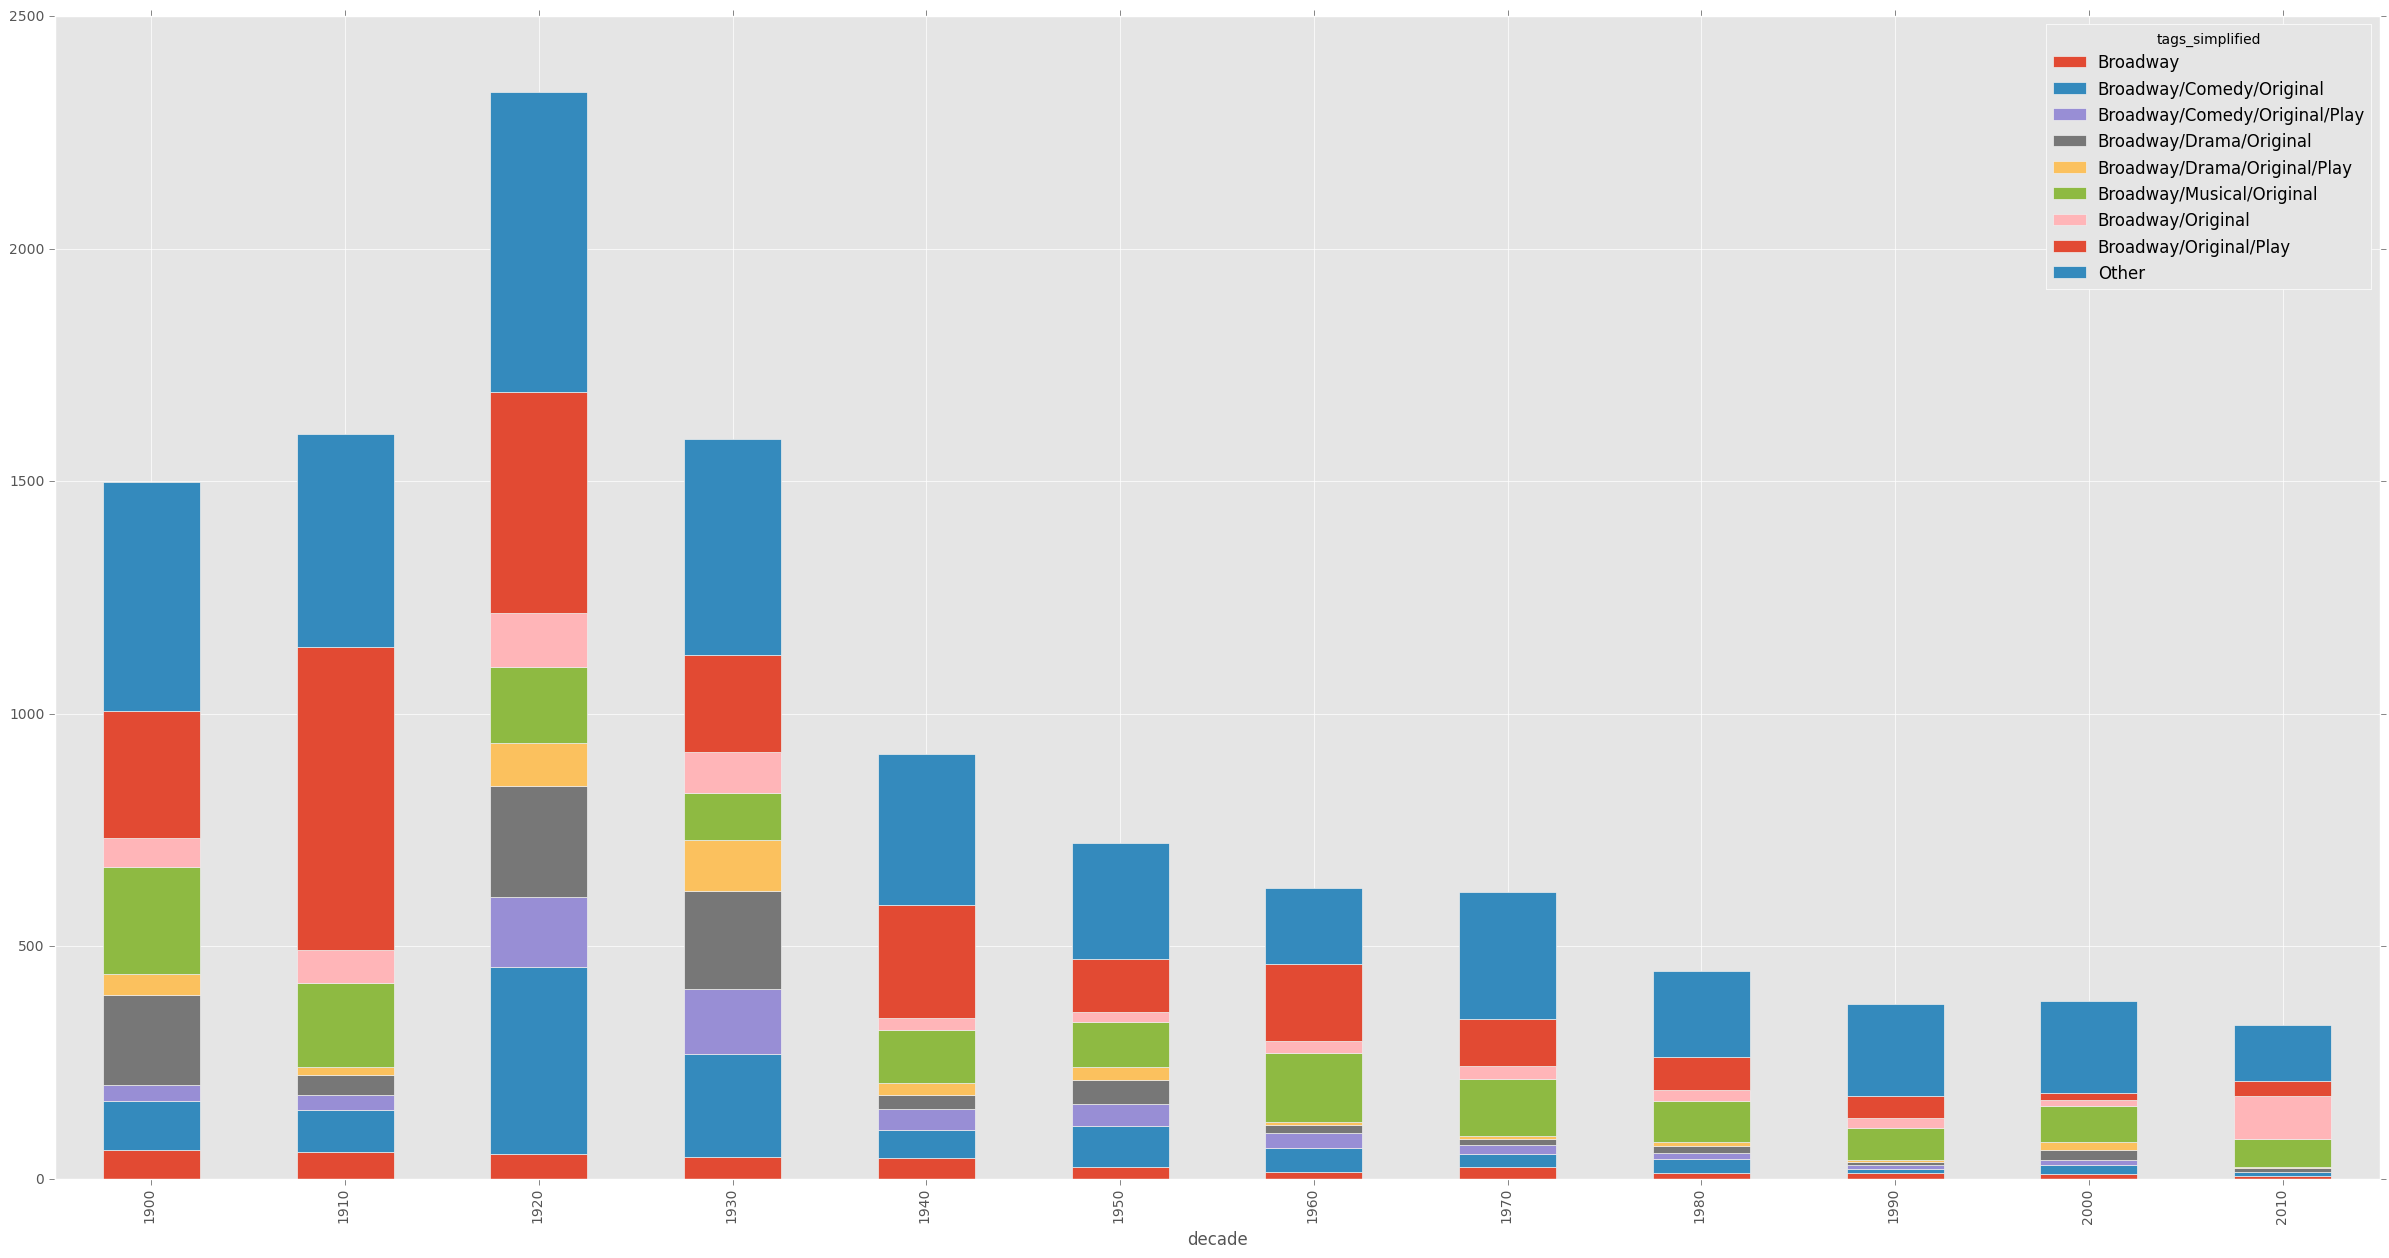

In [19]:
Shows[(Shows.year>1900)].groupby(['decade','tags_simplified']).nunique()['urlMinusVaultId'].unstack().plot.bar(stacked=True,figsize=(30,15))


In [ ]:
t = Shows[(Shows.year>1900)] \
    .groupby(['decade','isComedy']).nunique()['urlMinusVaultId'].unstack() #.plot.bar(stacked=True,figsize=(30,15))
t['Total'] = t.sum(axis=1)

DataFrame(t[True] / t['Total']).plot.bar(figsize=(30,15))

In [ ]:
Shows[(Shows.year>1900)].groupby(['decade','isMusical']).nunique()['urlMinusVaultId'].unstack().plot.bar(stacked=True,figsize=(30,15))

In [ ]:
Shows[~Shows.isMusical]

In [ ]:
t = Shows[(Shows.year>1900) & (Shows.tags.isin(['Broadway/Original/Play','Broadway/Musical/Original','Broadway/Comedy/Original','Broadway/Drama/Original']))] \
    .groupby(['decade','tags']).nunique()['urlMinusVaultId'].unstack() #.plot.bar(stacked=True,figsize=(30,15))
    
t['Total'] = t.sum(axis=1)

for tag in ['Broadway/Original/Play','Broadway/Musical/Original','Broadway/Comedy/Original','Broadway/Drama/Original']:
    t[tag] = t[tag] / t['Total']
    
t[['Broadway/Musical/Original']].plot(figsize=(30,15))

In [ ]:
DataFrame(nltk.FreqDist(list(Shows[Shows.year.between(1920,1930)].tags)).most_common()).set_index(0)[1].plot.pie()

In [ ]:
Shows[Shows.tags.str.contains('Theatrical Experience')]['url'][12824]

In [ ]:
Shows[Shows.tags.str.contains('Musical')].groupby('year').nunique()[['urlMinusVaultId']].plot.bar(figsize=(30,5))

In [ ]:
Shows[Shows.tags.str.contains('Thriller')]

In [ ]:
print len(set(Originals[Originals.year > 1970]['url'].apply(lambda url: '-'.join(url.split('-')[:-2]))))
print len(Originals[Originals.year > 1970]['url'])

In [ ]:
[getHtmlForYear(y) for y in range(1700,2018)]

In [ ]:
bss = [BeautifulSoup(urlopen(url)) for url in list(Theatres['url'])]

In [ ]:
nltk.Text(nltk.word_tokenize(''.join(theaterDescriptions))).collocations()

In [ ]:
theaterDescriptions = []

for i in range(39):    
    print i
    
    try:
        bs = bss[i]

        bspBio = bs.find('div', class_='bsp-bio')

        bspBioTitle = bspBio.find('h2', class_='bsp-bio-title').getText()

        print bspBioTitle

        bspBioText = ''
        bspBioFullTextUrl = ''
        if (bspBio.find('div', class_='bsp-bio-text')):
            bspBioText =  bspBio.find('div', class_='bsp-bio-text').getText('\n')
            if (bspBio.find('div', class_='bsp-bio-text').find('a')):
                if (bspBio.find('div', class_='bsp-bio-text').find('a').has_attr('href')):
                    bspBioFullTextUrl = bspBio.find('div', class_='bsp-bio-text').find('a')['href']

        bspBioLists =bspBio.find('div', class_='bsp-bio-lists')
        bspBioListPairs = [(re.sub(':$', '', li.find('span').getText()), li.find('span').nextSibling) for li in bspBioLists.find_all('li')]


        print bspBioText
        theaterDescriptions.append(bspBioText)
        
        print bspBioFullTextUrl
        print bspBioListPairs
    except:
        print("Unexpected error:", sys.exc_info()[0])

In [ ]:
t = DataFrame(theaterDescriptions)
t[0]=t[0].str.strip()
t.to_csv('theaterDescriptions.csv',index=False,encoding='utf-8')


In [ ]:
text = nltk.word_tokenize(theaterDescriptions[10])
nltk.pos_tag(text)

In [ ]:
season2017 = json.loads(''.join(urlopen('http://www.playbill.com/ajax/loadProdSeason.jsp?year=2017&start=0&limit=1000').readlines()))


In [ ]:


Shows = DataFrame([{'year': year, 'url': x['url'], 'title': x['title']}  for year in range(1701,2018) for x in seasonShows(year)])

Shows['title'] = Shows['title'].str.strip()



In [ ]:
print len(Shows.groupby('url').count())
print len(Shows)

In [ ]:
list(Shows[Shows['url'].str.contains('carousel')]['url'])

In [ ]:
carousels

In [ ]:
url =  '/production/carousel-2017-2018'

url = 'http://www.playbill.com' + url

bs = BeautifulSoup(urlopen(url))

In [ ]:
tags = [getTags(url) for url in list(Shows['url'])]

In [ ]:
getTags('/production/carousel-2017-2018')

In [ ]:
carousels= list(Shows[Shows['url'].str.contains('carousel')]['url'])

In [ ]:
previousShows = 'http://www.playbill.com/ajax/loadVenueShow.jsp?id=00000150-aa9f-d8be-af71-ffbf689b0003&start=0&limit=1000&venue=00000150-aacd-d8be-af71-ffef18860005'

In [ ]:
url='http://www.playbill.com/production/carousel-2017-2018'
bs = BeautifulSoup(urlopen(url))

[json.loads(x['data-bsp-carousel-options'])['themeConfig']['dynamicSlideLoadNextUrl'] for x 
 in bs.find_all('div', class_='gallery-module gallery-module-horizontal')]

In [ ]:
url='http://www.playbill.com/venue/imperial-theatre-vault-0000000201'
bs = BeautifulSoup(urlopen(url))

[json.loads(x['data-bsp-carousel-options'])['themeConfig']['dynamicSlideLoadNextUrl'] for x 
 in bs.find_all('div', class_='gallery-module gallery-module-horizontal')]

In [ ]:
url='http://www.playbill.com/production/carousel-2017-2018'
bs = BeautifulSoup(urlopen(url))

In [ ]:
getProductionHtml('http://www.playbill.com/production/carousel-2017-2018')


In [ ]:
str(urlopen(url))

In [ ]:
url.startswith('http://www.playbill.com/')

In [ ]:
f = open('production/my-fair-lady-uris-theatre-vault-0000011053.html', "r")
bs = BeautifulSoup(f.read())
f.close()

bs

In [ ]:
[json.loads(x['data-bsp-carousel-options'])['themeConfig']['dynamicSlideLoadNextUrl'] for x 
 in bs.find_all('div', class_='gallery-module gallery-module-horizontal')]

In [ ]:
getTagsFromBs(bs)